In this file I will try to create a model that given an image of a spectrogram it will detect wich genere of music it is from.


In [25]:
import torch.nn as nn
import torch
from torchvision.utils import make_grid
#from google.colab import drive
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as tf
import pickle
import numpy as np
import torch.nn.functional as F
import torchvision.transforms as transforms
import cv2
import time
import os
from sklearn.model_selection import train_test_split



In [2]:
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/deep learning/'
results_path = '/content/drive/My Drive/deep learning/Results/'


Mounted at /content/drive


999


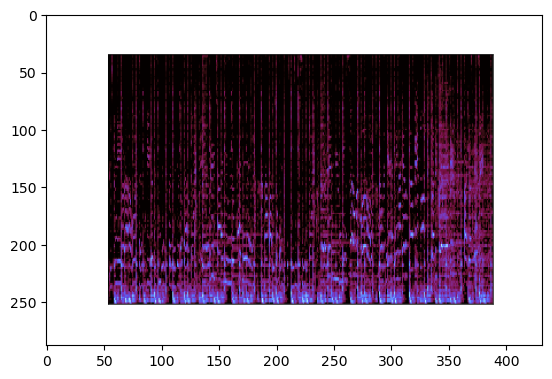

In [23]:
img_data_array=[]
class_name=[]
img_folder = data_path + 'Data/images_original'

for dir1 in os.listdir(img_folder):
    if dir1 != '.DS_Store':
        for file in os.listdir(os.path.join(img_folder, dir1)):
            image_path= os.path.join(img_folder, dir1,  file)
            image= cv2.imread( image_path, cv2.COLOR_BGR2RGB) 
            img_data_array.append(image)
            class_name.append(dir1)

print(len(img_data_array))
plt.imshow(img_data_array[0])

In [35]:
xTrain,xTest,yTrain,yTest = train_test_split(img_data_array,target_val,test_size=0.2,random_state=42)

target_dict = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5,
                    'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}

target_val=  [target_dict[class_name[i]] for i in range(len(class_name))]

num_classes = 10
print(num_classes)

10


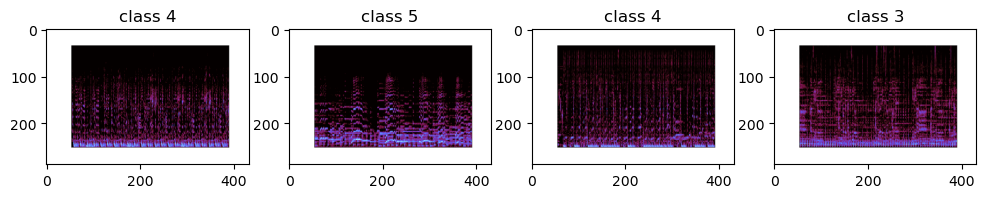


xTrain shape:  (799, 288, 432, 3)


In [36]:
plt.figure(figsize=(12,12))
plt.subplot(1,4,1)
plt.imshow(xTrain[0])
plt.title('class '+ str(yTrain[0]))
plt.subplot(1,4,2)
plt.imshow(xTrain[240])
plt.title('class '+ str(yTrain[240]))
plt.subplot(1,4,3)
plt.imshow(xTrain[602])
plt.title('class '+ str(yTrain[602]))
plt.subplot(1,4,4)
plt.imshow(xTrain[732])
plt.title('class '+ str(yTrain[732]))

plt.show()
print()
print('xTrain shape: ',np.shape(xTrain))


**REMOVE WHITE PADDING**

(216, 334, 3)


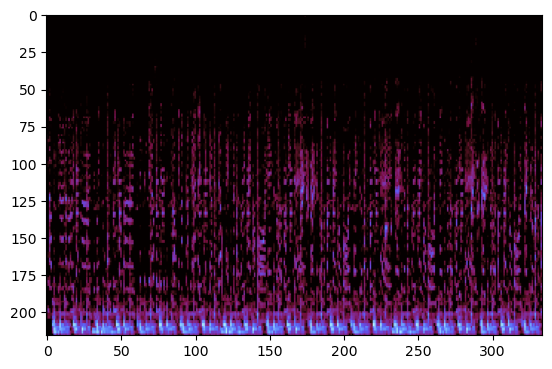

In [37]:
for i,image in enumerate(xTrain):
    xTrain[i]=image[36:252,54:388]
for i,image in enumerate(xTest):
    xTest[i]=image[36:252,54:388]

plt.imshow(xTrain[0])
print(np.shape(xTrain[0]))

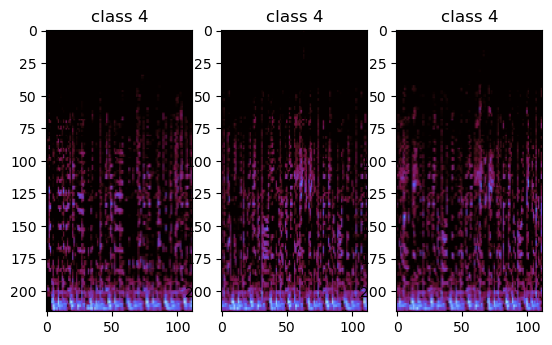

"\nplt.subplot(1,3,1)\nplt.imshow(xTest_da[0])\nplt.title('class '+ str(yTest_da[0]))\nplt.subplot(1,3,2)\nplt.imshow(xTest_da[1])\nplt.title('class '+ str(yTest_da[1]))\nplt.subplot(1,3,3)\nplt.imshow(xTest_da[2])\nplt.title('class '+ str(yTest_da[2]))\nplt.show()\n\nplt.imshow(xTest[0])\nplt.title('class '+ str(yTest[0]))\nplt.show()"

In [38]:
##separate each 30s segment into shorter segments, initial dimensions:(216, 334) --> modify 334
IMG_HEIGHT = 216
IMG_WIDTH = 336
partitions = 3

for i,image in enumerate(xTrain):
    xTrain[i] = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT ))
for i,image in enumerate(xTest):
    xTest[i] = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))

xTrain_da = []
yTrain_da = []
xTest_da = []
yTest_da = []

for j in range(0,len(xTrain)):
    for i in range(0,partitions):
        xTrain_da.append(xTrain[j][:,int(np.floor(i*(IMG_WIDTH//partitions))):int(np.floor((i+1)*(IMG_WIDTH//partitions))),:])
        yTrain_da.append(yTrain[j])

for j in range(0,len(xTest)):
    for i in range(0,partitions):
        xTest_da.append(xTest[j][:,int(np.floor(i*(IMG_WIDTH//partitions))):int(np.floor((i+1)*(IMG_WIDTH//partitions))),:])
        yTest_da.append(yTest[j])

plt.subplot(1,3,1)
plt.imshow(xTrain_da[0])
plt.title('class '+ str(yTrain_da[0]))
plt.subplot(1,3,2)
plt.imshow(xTrain_da[1])
plt.title('class '+ str(yTrain_da[1]))
plt.subplot(1,3,3)
plt.imshow(xTrain_da[2])
plt.title('class '+ str(yTrain_da[2]))
plt.show()
'''
plt.imshow(xTrain[0])
plt.title('class '+ str(yTrain[0]))
plt.show()
'''
'''
plt.subplot(1,3,1)
plt.imshow(xTest_da[0])
plt.title('class '+ str(yTest_da[0]))
plt.subplot(1,3,2)
plt.imshow(xTest_da[1])
plt.title('class '+ str(yTest_da[1]))
plt.subplot(1,3,3)
plt.imshow(xTest_da[2])
plt.title('class '+ str(yTest_da[2]))
plt.show()

plt.imshow(xTest[0])
plt.title('class '+ str(yTest[0]))
plt.show()'''

In [40]:

#Making native class loader
class MEL(torch.utils.data.Dataset):
    # Initialization method for the dataset
    def __init__(self,xTrain,yTrain,transform = None):
        self.data = xTrain
        self.labels = yTrain
        self.transform = transform
     # What to do to load a single item in the dataset ( read image and label)
    def __getitem__(self, index):
        data = self.data[index]
        lbl = self.labels[index]

        #data = self.data
        # Apply a trasnformaiton to the image if it is indicated in the initalizer
        if self.transform is not None :
            data = self.transform(data)

        # return the image and the label
        return data,lbl

        pass

    # Return the number of images
    def __len__(self):
        return len(self.data)

# Create train data loader
tr = tf.Compose([
        tf.ToTensor(),
        tf.Normalize(mean = [.5], std = [.5])
        ])

MELTest_da = MEL(xTest_da, yTest_da,tr)
test_loader_da = torch.utils.data.DataLoader(dataset=MELTest_da,
                                               batch_size=200,
                                               shuffle=True)
MELTrain_da = MEL(xTrain_da,yTrain_da,tr)
train_loader_da = torch.utils.data.DataLoader(dataset=MELTrain_da,
                                               batch_size=64,
                                               shuffle=True)
MELTest = MEL(xTest, yTest,tr)
test_loader = torch.utils.data.DataLoader(dataset=MELTest,
                                               batch_size=64,
                                               shuffle=True)
MELTrain = MEL(xTrain,yTrain,tr)
train_loader = torch.utils.data.DataLoader(dataset=MELTrain,
                                               batch_size=200,
                                               shuffle=True)

In [41]:
def compute_model_params(model):
  params = 0
  for p in model.parameters():
    params+= p.numel()
  return params

In [42]:
#initial dimensions = (288, 432, 4)
class Squeezev2(nn.Module):
    def __init__(self, num_classes = num_classes):

        super(Squeezev2, self).__init__()

        self.conv1 = nn.Conv2d(4,64,kernel_size = 5, padding = 2)
        self.bnorm = nn.BatchNorm2d(64)

        self.squeeze1 = nn.Conv2d(64,16,kernel_size=1)
        self.expand11 = nn.Conv2d(16,64,kernel_size=1)
        self.expand12 = nn.Conv2d(16,64,kernel_size=3,padding=1)
        self.bnorm1 = nn.BatchNorm2d(64)

        self.squeeze2 = nn.Conv2d(128,16,kernel_size=1)
        self.expand21 = nn.Conv2d(16,64,kernel_size=1)
        self.expand22 = nn.Conv2d(16,64,kernel_size=3,padding=1)
        self.bnorm2 = nn.BatchNorm2d(64)

        self.squeeze3 = nn.Conv2d(128,32,kernel_size=1)
        self.expand31 = nn.Conv2d(32,128,kernel_size=1)
        self.expand32 = nn.Conv2d(32,128,kernel_size=3,padding=1)
        self.bnorm3 = nn.BatchNorm2d(128)

        self.squeeze4 = nn.Conv2d(256,32,kernel_size=1)
        self.expand41 = nn.Conv2d(32,128,kernel_size=1)
        self.expand42 = nn.Conv2d(32,128,kernel_size=3,padding=1)
        self.bnorm4 = nn.BatchNorm2d(128)

        self.squeeze5 = nn.Conv2d(256,64,kernel_size=1)
        self.expand51 = nn.Conv2d(64,192,kernel_size=1)
        self.expand52 = nn.Conv2d(64,192,kernel_size=3,padding=1)
        self.bnorm5 = nn.BatchNorm2d(192)

        self.squeeze6 = nn.Conv2d(384,64,kernel_size=1)
        self.expand61 = nn.Conv2d(64,192,kernel_size=1)
        self.expand62 = nn.Conv2d(64,192,kernel_size=3,padding=1)
        self.bnorm6 = nn.BatchNorm2d(192)

        self.fc1 = nn.Linear(768, 1000) #1img:768  ,2img:1536, 3img:768
        self.fc2 = nn.Linear(1000, num_classes)
        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        self.avgpool = nn.AvgPool2d(kernel_size=3,stride=2)

    def forward(self, x):

        #conv initial
        print('x:',np.shape(x))
        out = self.conv1(x)
        #batchnorm initial
        out = self.bnorm(out)
        out = self.relu(out)
        out = self.dropout(out)
        print('out1:',np.shape(out))
        #pool
        out = self.maxpool(out)
        print('pool1:',np.shape(out))
        #squeeze 1
        out = self.squeeze1(out)
        out = self.relu(out)
        print('squeeze1:',np.shape(out))
        #expand 1
        out11 = self.bnorm1(self.expand11(out))
        out12 = self.bnorm1(self.expand12(out))
        out1 = torch.cat([self.relu(out11),self.relu(out12)],dim=1)
        print('expand1:',np.shape(out1))
        #out1 = self.dropout(out1)

        #squeeze 2
        out = self.squeeze2(out1)
        out = self.relu(out)
        print('squeeze2:',np.shape(out))
        #expand 2
        out21 = self.bnorm2(self.expand21(out))
        out22 = self.bnorm2(self.expand22(out))
        out2 = torch.cat([self.relu(out21),self.relu(out22)],dim=1) + out1
        out2 = self.dropout(out2)
        print('expand2:',np.shape(out2))

        #pool
        out = self.maxpool(out2)
        print('pool2:',np.shape(out))

        #squeeze 3
        out = self.squeeze3(out)
        out = self.relu(out)
        print('squeeze3:',np.shape(out))
        #expand 3
        out31 = self.bnorm3(self.expand31(out))
        out32 = self.bnorm3(self.expand32(out))
        out3 = torch.cat([self.relu(out31),self.relu(out32)],dim=1)
        out3 = self.dropout(out3)
        print('expand3:',np.shape(out3))

        #pool
        out3 = self.maxpool(out3)
        print('pool3:',np.shape(out3))

        #squeeze 4
        out = self.squeeze4(out3)
        out = self.relu(out)
        print('squeeze3:',np.shape(out))
        #expand 3
        out41 = self.bnorm4(self.expand41(out))
        out42 = self.bnorm4(self.expand42(out))
        out4 = torch.cat([self.relu(out41),self.relu(out42)],dim=1)
        out4= self.dropout(out4)
        print('expand4:',np.shape(out4))

        #pool
        out4 = self.maxpool(out4)
        print('pool4:',np.shape(out4))

        #squeeze 5
        out = self.squeeze5(out4)
        out = self.relu(out)
        print('squeeze5:',np.shape(out))

        #expand 5
        out51 = self.bnorm5(self.expand51(out))
        out52 = self.bnorm5(self.expand52(out))
        out5 = torch.cat([self.relu(out51),self.relu(out52)],dim=1)
        out5 = self.dropout(out5)
        print('expand5:',np.shape(out5))

        out5 = self.maxpool(out5)
        print('pool5:',np.shape(out5))

        #squeeze 6
        out = self.squeeze6(out5)
        out = self.relu(out)
        print('squeeze6:',np.shape(out))

        #expand 6
        out61 = self.bnorm6(self.expand61(out))
        out62 = self.bnorm6(self.expand62(out))
        out6 = torch.cat([self.relu(out61),self.relu(out62)],dim=1)
        out6 = self.dropout(out6)
        print('expand6:',np.shape(out6))

        out = self.avgpool(out6)
        print('pool6:',np.shape(out))

        out = out.reshape(out.size(0), -1)
        print('reshape:',np.shape(out))

        out = self.fc1(out)
        out = self.dropout(out)
        print('fc1:',np.shape(out))

        out = self.fc2(out)
        print('fc2:',np.shape(out))

        #WE DON'T USE SOFTMAX BC WE ARE USING CROSS ENTROPY LOSS
        return out

model = Squeezev2(num_classes=10)
n_params = compute_model_params(model)
print("Squeezev2 Parameters: " + str(n_params))


Squeezev2 Parameters: 1193378


In [ ]:

class Squeeze(nn.Module):
    def __init__(self, num_classes = num_classes):

        super(Squeeze, self).__init__()

        self.conv1 = nn.Conv2d(4,64,kernel_size = 5, padding = 1)
        self.bnorm = nn.BatchNorm2d(64)

        self.squeeze1 = nn.Conv2d(64,16,kernel_size=1)
        self.expand11 = nn.Conv2d(16,64,kernel_size=1)
        self.expand12 = nn.Conv2d(16,64,kernel_size=3,padding=1)
        self.bnorm1 = nn.BatchNorm2d(64)

        self.squeeze2 = nn.Conv2d(128,16,kernel_size=1)
        self.expand21 = nn.Conv2d(16,64,kernel_size=1)
        self.expand22 = nn.Conv2d(16,64,kernel_size=3,padding=1)
        self.bnorm2 = nn.BatchNorm2d(64)

        self.squeeze3 = nn.Conv2d(128,32,kernel_size=1)
        self.expand31 = nn.Conv2d(32,128,kernel_size=1)
        self.expand32 = nn.Conv2d(32,128,kernel_size=3,padding=1)
        self.bnorm3 = nn.BatchNorm2d(128)

        self.squeeze4 = nn.Conv2d(256,32,kernel_size=1)
        self.expand41 = nn.Conv2d(32,128,kernel_size=1)
        self.expand42 = nn.Conv2d(32,128,kernel_size=3,padding=1)
        self.bnorm4 = nn.BatchNorm2d(128)

        self.squeeze5 = nn.Conv2d(256,64,kernel_size=1)
        self.expand51 = nn.Conv2d(64,192,kernel_size=1)
        self.expand52 = nn.Conv2d(64,192,kernel_size=3,padding=1)
        self.bnorm5 = nn.BatchNorm2d(192)

        self.squeeze6 = nn.Conv2d(384,64,kernel_size=1)
        self.expand61 = nn.Conv2d(64,192,kernel_size=1)
        self.expand62 = nn.Conv2d(64,192,kernel_size=3,padding=1)
        self.bnorm6 = nn.BatchNorm2d(192)

        self.squeeze7 = nn.Conv2d(384,64,kernel_size=1)
        self.expand71 = nn.Conv2d(64,192,kernel_size=1)
        self.expand72 = nn.Conv2d(64,192,kernel_size=3,padding=1)
        self.bnorm6 = nn.BatchNorm2d(192)

        self.fc1 = nn.Linear(768 , 1000)
        self.fc2 = nn.Linear(1000, num_classes)
        self.maxpool= nn.MaxPool2d(kernel_size=3, stride=3)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        self.avgpool = nn.AvgPool2d(kernel_size=3,stride=3)

    def forward(self, x):

        #conv initial
        print('x:',np.shape(x))
        out = self.conv1(x)
        #batchnorm initial
        out = self.bnorm(out)
        out = self.relu(out)
        out = self.dropout(out)
        print('conv1:',np.shape(out))
        #pool
        out = self.maxpool(out)
        print('pool1:',np.shape(out))

        #squeeze 1
        out = self.squeeze1(out)
        out = self.relu(out)
        print('squeeze1:',np.shape(out))
        #expand 1
        out11 = self.bnorm1(self.expand11(out))
        out12 = self.bnorm1(self.expand12(out))
        out1 = torch.cat([self.relu(out11),self.relu(out12)],dim=1)
        print('ezpand1:',np.shape(out1))
        #out1 = self.dropout(out1)

        #squeeze 2
        out = self.squeeze2(out1)
        out = self.relu(out)
        print('squeeze2:',np.shape(out))
        #expand 2
        out21 = self.bnorm2(self.expand21(out))
        out22 = self.bnorm2(self.expand22(out))
        out2 = torch.cat([self.relu(out21),self.relu(out22)],dim=1) + out1
        out2 = self.dropout(out2)
        print('expand2:',np.shape(out2))
        #pool
        out = self.maxpool(out2)
        print('pool2:',np.shape(out))

        #squeeze 3
        out = self.squeeze3(out)
        out = self.relu(out)
        print('squeeze3:',np.shape(out))
        #expand 3
        out31 = self.bnorm3(self.expand31(out))
        out32 = self.bnorm3(self.expand32(out))
        out3 = torch.cat([self.relu(out31),self.relu(out32)],dim=1)
        out3 = self.dropout(out3)
        print('expand3:',np.shape(out3))

        #squeeze 4
        out = self.squeeze4(out3)
        out = self.relu(out)
        print('squeeze4:',np.shape(out))
        #expand 4
        out41 = self.bnorm4(self.expand41(out))
        out42 = self.bnorm4(self.expand42(out))
        out4 = torch.cat([self.relu(out41),self.relu(out42)],dim=1)+out3
        out4= self.dropout(out4)
        print('expand4:',np.shape(out))
        #pool

        out4 = self.maxpool(out4)
        print('pool3:',np.shape(out4))

        #squeeze 5
        out = self.squeeze5(out4)
        out = self.relu(out)
        print('squeeze5:',np.shape(out))
        #expand 5
        out51 = self.bnorm5(self.expand51(out))
        out52 = self.bnorm5(self.expand52(out))
        out5 = torch.cat([self.relu(out51),self.relu(out52)],dim=1)
        out5 = self.dropout(out5)
        print('squeeze5:',np.shape(out5))

        #squeeze 6
        out = self.squeeze6(out5)
        out = self.relu(out)
        print('squeeze6:',np.shape(out))
        #expand 5
        out61 = self.bnorm6(self.expand61(out))
        out62 = self.bnorm6(self.expand62(out))
        out6 = torch.cat([self.relu(out61),self.relu(out62)],dim=1)+out5
        out6 = self.dropout(out6)
        print('expand6:',np.shape(out6))

        out = self.maxpool(out6)
        print('pool4:',np.shape(out))

        #squeeze 7
        out = self.squeeze7(out)
        out = self.relu(out)
        print('squeeze7:',np.shape(out))
        #expand 7
        out71 = self.bnorm5(self.expand71(out))
        out72 = self.bnorm5(self.expand72(out))
        out7 = torch.cat([self.relu(out71),self.relu(out72)],dim=1)
        out7 = self.dropout(out5)
        print('expand7:',np.shape(out7))

        out = self.avgpool(out7)
        print('pool5:',np.shape(out))

        out = out.reshape(out.size(0), -1)
        print('reshape:',np.shape(out))

        out = self.fc1(out)
        out = self.dropout(out)
        print('fc1:',np.shape(out))

        out = self.fc2(out)
        print('fc2:',np.shape(out))
        #WE DON'T USE SOFTMAX BC WE ARE USING CROSS ENTROPY LOSS
        return out

model = Squeeze(num_classes=10)
n_params = compute_model_params(model)
print("Squeezev2 Parameters: " + str(n_params))


**SIMPLE**

In [ ]:


class Simple(nn.Module):
    def __init__(self, num_classes = num_classes):

        super(Simple, self).__init__()

        self.conv1 = nn.Conv2d(4,64,kernel_size=3,padding=1)
        self.bnorm1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64,128,kernel_size=5,padding=1)
        self.bnorm2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128,128,kernel_size=3,padding=1)
        self.bnorm3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128,256,kernel_size=5,padding=1)
        self.bnorm4 = nn.BatchNorm2d(256)

        self.conv5 = nn.Conv2d(256,128,kernel_size=5,padding=1)
        self.bnorm5 = nn.BatchNorm2d(128)

        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(640, num_classes) #2img: 1920, 3img:640
        self.dropout = nn.Dropout(0.2)

        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        print('x:',np.shape(x))
        out = self.conv1(x)
        out = self.bnorm1(out)
        out = self.relu(out)
        out = self.dropout(out)
        print('con1:',np.shape(out))

        out = self.maxpool(out)
        print('pool1:',np.shape(out))

        out = self.conv2(out)
        out = self.bnorm2(out)
        out = self.relu(out)
        out = self.dropout(out)
        print('conv2:',np.shape(out))

        out = self.maxpool(out)
        print('pool2:',np.shape(out))

        out = self.conv3(out)
        out = self.bnorm3(out)
        out = self.relu(out)
        out = self.dropout(out)
        print('conv3:',np.shape(out))

        out = self.maxpool(out)
        print('pool3:',np.shape(out))

        out = self.conv4(out)
        out = self.bnorm4(out)
        out = self.relu(out)
        out = self.dropout(out)
        print('conv4:',np.shape(out))

        out = self.maxpool(out)
        print('pool4:',np.shape(out))

        out = self.conv5(out)
        out = self.bnorm5(out)
        out = self.relu(out)
        out = self.dropout(out)
        print('conv5:',np.shape(out))

        out = self.maxpool(out)
        print('pool5:',np.shape(out))

        out = out.reshape(out.size(0), -1)
        print('reshape:',np.shape(out))

        out = self.fc1(out)
        print('fc1:',np.shape(out))
        #WE DON'T USE SOFTMAX BC WE ARE USING CROSS ENTROPY LOSS
        return out

model = Simple(num_classes=10)
n_params = compute_model_params(model)
print("Simple Parameters: " + str(n_params))


**SIMPLE V2**

In [9]:

class Simplev2(nn.Module):
    def __init__(self, num_classes = num_classes):

        super(Simplev2, self).__init__()

        self.conv1 = nn.Conv2d(4,64,kernel_size=5,padding=1)
        self.bnorm1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64,128,kernel_size=3,padding=1)
        self.bnorm2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128,256,kernel_size=3,padding=1)
        self.bnorm3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256,405,kernel_size=3,padding=1)
        self.bnorm4 = nn.BatchNorm2d(405)

        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(1215 , 500) #2img:405 3img:1215
        self.fc2 = nn.Linear(500, num_classes)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.5)

        self.maxpool= nn.MaxPool2d(kernel_size=3, stride=3) #2img: 3,3, 3img: 3,3
        self.avgpool = nn.AvgPool2d(kernel_size=3,stride=2) #2img: 5,3, 3img: 3,2

    def forward(self, x):

        print('x:',np.shape(x))
        out = self.conv1(x)
        out = self.bnorm1(out)
        out = self.relu(out)
        #out = self.dropout(out)
        print('conv1:',np.shape(out))

        out = self.maxpool(out)
        print('pool1:',np.shape(out))

        out = self.conv2(out)
        out = self.bnorm2(out)
        out = self.relu(out)
        #out = self.dropout(out)
        print('conv2:',np.shape(out))

        out = self.maxpool(out)
        print('pool2:',np.shape(out))

        out = self.conv3(out)
        out = self.bnorm3(out)
        out = self.relu(out)
        #out = self.dropout(out)
        print('conv3:',np.shape(out))

        out = self.maxpool(out)
        print('pool3:',np.shape(out))

        out = self.conv4(out)
        out = self.bnorm4(out)
        out = self.relu(out)
        out = self.dropout1(out)
        print('conv4:',np.shape(out))

        out = self.avgpool(out)
        print('pool4:',np.shape(out))

        out = out.reshape(out.size(0), -1)
        print('reshape:',np.shape(out))

        out = self.fc1(out)
        out = self.dropout2(out)
        print('fc1:',np.shape(out))

        out = self.fc2(out)
        print('fc2:',np.shape(out))
        #out = self.dropout(out)
        #WE DON'T USE SOFTMAX BC WE ARE USING CROSS ENTROPY LOSS
        return out

model = Simplev2(num_classes=10)
n_params = compute_model_params(model)
print("Simplev2 Parameters: " + str(n_params))


Simplev2 Parameters: 1923729


In [ ]:

class Simplev3(nn.Module):
    def __init__(self, num_classes = num_classes):

        super(Simplev3, self).__init__()

        self.conv1 = nn.Conv2d(4,32,kernel_size=3,padding=1)
        self.bnorm1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32,64,kernel_size=3,padding=1)
        self.bnorm2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64,128,kernel_size=3,padding=1)
        self.bnorm3 = nn.BatchNorm2d(128)

        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(384 , 500) #1img: 1920, 2img:768, 3img: 384
        self.fc2 = nn.Linear(500, num_classes)
        self.dropout = nn.Dropout(0.3)

        self.maxpool= nn.MaxPool2d(kernel_size=3, stride=3)
        self.avgpool = nn.AvgPool2d(kernel_size=3,stride=2)

    def forward(self, x):
        print('x:',np.shape(xTrain))
        out = self.conv1(x)
        out = self.bnorm1(out)
        out = self.relu(out)
        #out = self.dropout(out)
        print('conv1:',np.shape(out))

        out = self.maxpool(out)
        print('pool1:',np.shape(out))

        out = self.conv2(out)
        out = self.bnorm2(out)
        out = self.relu(out)
        #out = self.dropout(out)
        print('conv2:',np.shape(out))

        out = self.maxpool(out)
        print('pool2:',np.shape(out))

        out = self.conv3(out)
        out = self.bnorm3(out)
        out = self.relu(out)
        out = self.dropout(out)
        print('conv3:',np.shape(out))

        out = self.maxpool(out)
        print('pool3:',np.shape(out))

        out = self.avgpool(out)
        print('pool4:',np.shape(out))

        out = out.reshape(out.size(0), -1)
        print('reshape:',np.shape(out))

        out = self.fc1(out)
        out = self.dropout(out)
        print('fc1:',np.shape(out))

        out = self.fc2(out)
        out = self.dropout(out)
        print('fc2:',np.shape(out))
        #WE DON'T USE SOFTMAX BC WE ARE USING CROSS ENTROPY LOSS
        return out

model = Simplev3(num_classes=10)
n_params = compute_model_params(model)
print("Simplev3 Parameters: " + str(n_params))

Simplev3 Parameters: 291494


**TRAIN AND TEST FUNCTIONS**

In [10]:
def train(CNN, train_loader, test_loader,optimizer, num_epochs=5, model_name='model.ckpt', device='cpu'):
    CNN.train() # Set the model in train mode
    total_step = len(train_loader)
    losses_list = []
    test_acc_list = []
    train_acc_list = []
    criterion = nn.CrossEntropyLoss()
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        loss_avg = 0
        nBatches = 0

        for i, (images, labels) in enumerate(train_loader):
            # Get batch of samples and labels
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = CNN(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_avg += loss.cpu().item()
            nBatches+=1

            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))

        acc_test,pred,labels = test(CNN,test_loader)
        test_acc_list.append(acc_test)
        acc_train,pred,labels = test(CNN,train_loader)
        train_acc_list.append(acc_train)

        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        print(f'Epoch: {epoch+1}, test accuracy:{acc_test}')
        losses_list.append(loss_avg / nBatches)
        torch.save(CNN.state_dict(), results_path+ '/' + model_name)
    print('last train accuracy:', train_acc_list[-1])

    return losses_list, test_acc_list, train_acc_list

def test(CNN, test_loader):
  with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            # get network predictions
            outputs = CNN(images)

            # get predicted class
            _, predicted = torch.max(outputs.data, 1)


            # compare with the ground-truth
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # return accuracy


        return 100 * correct / total, predicted,labels

def confusion_matrix(labels,predicted):
    cm = metrics.confusion_matrix(labels, predicted)
    fig, ax = plt.subplots(figsize=(8,6))
    sns.heatmap(cm, annot=True)
    plt.title('results of SVM clinical data model')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


In [15]:

#Train MyModel
Squeeze_model = Squeezev2()

#Initialize optimizer
learning_rate = .0001
#optimizer = torch.optim.SGD(Squeeze_model.parameters(),lr = learning_rate, weight_decay=1e-6, momentum=0.9) #,
optimizer = torch.optim.Adam(Squeeze_model.parameters(),lr = learning_rate,weight_decay=1e-4)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Squeeze_model = Squeeze_model.to(device)

losses_list,test_acc_list,train_acc_list = train(Squeeze_model, train_loader_da,test_loader_da, optimizer, num_epochs=100, model_name='Squeezev2.ckpt', device=device)
#0.28,66 ; 0.45,62

x: torch.Size([64, 4, 216, 112])
out1: torch.Size([64, 64, 216, 112])
pool1: torch.Size([64, 64, 108, 56])
squeeze1: torch.Size([64, 16, 108, 56])
expand1: torch.Size([64, 128, 108, 56])
squeeze2: torch.Size([64, 16, 108, 56])
expand2: torch.Size([64, 128, 108, 56])
pool2: torch.Size([64, 128, 54, 28])
squeeze3: torch.Size([64, 32, 54, 28])
expand3: torch.Size([64, 256, 54, 28])
pool3: torch.Size([64, 256, 27, 14])
squeeze3: torch.Size([64, 32, 27, 14])
expand4: torch.Size([64, 256, 27, 14])
pool4: torch.Size([64, 256, 13, 7])
squeeze5: torch.Size([64, 64, 13, 7])
expand5: torch.Size([64, 384, 13, 7])
pool5: torch.Size([64, 384, 6, 3])
squeeze6: torch.Size([64, 64, 6, 3])
expand6: torch.Size([64, 384, 6, 3])
pool6: torch.Size([64, 384, 2, 1])
reshape: torch.Size([64, 768])
fc1: torch.Size([64, 1000])
fc2: torch.Size([64, 10])
x: torch.Size([64, 4, 216, 112])
out1: torch.Size([64, 64, 216, 112])
pool1: torch.Size([64, 64, 108, 56])
squeeze1: torch.Size([64, 16, 108, 56])
expand1: torch.

KeyboardInterrupt: ignored

In [ ]:

#Train MyModel
Squeeze_model = Squeeze()

#Initialize optimizer
learning_rate = .0001
#optimizer = torch.optim.SGD(Squeeze_model.parameters(),lr = learning_rate, weight_decay=1e-6, momentum=0.9) #,
optimizer = torch.optim.Adam(Squeeze_model.parameters(),lr = learning_rate,weight_decay=1e-4)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Squeeze_model = Squeeze_model.to(device)

losses_list,test_acc_list,train_acc_list = train(Squeeze_model, train_loader_da,test_loader_da, optimizer, num_epochs=100, model_name='Squeeze.ckpt', device=device)
#0.28,66 ; 0.45,62

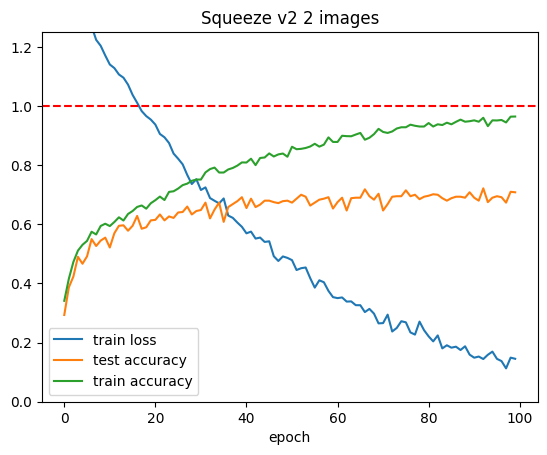

In [ ]:
for i in range(0,len(test_acc_list)):
    test_acc_list[i] = test_acc_list[i]/100
for i in range(0,len(train_acc_list)):
    train_acc_list[i] = train_acc_list[i]/100

plt.plot(losses_list,label='train loss')
plt.plot(test_acc_list,label='test accuracy')
plt.plot(train_acc_list,label = 'train accuracy')
plt.xlabel('epoch')
plt.title('Squeeze v2 2 images')
plt.axhline(y=1, xmin=0, xmax=100, ls='dashed',color='r')
plt.ylim((0,1.25))
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
from sklearn import metrics
import seaborn as sns
# Show results for all the trained models


my_net = Squeeze()
my_net.load_state_dict(torch.load(results_path + 'Squeeze.ckpt'))
device = torch.device( 'cpu')
my_net = my_net.to(device)

acc,predicted = test(my_net, test_loader)
print('Accuracy Squeeze: ' + str(acc))

#print(classification_report(yTest_da, predicted)) #classification report


In [ ]:

#Train MyModel
Simple_model = Simple()

#Initialize optimizer
learning_rate = .0001

#optimizer = torch.optim.SGD(Simple_model.parameters(),lr = learning_rate, momentum=0.9,weight_decay = 1e-5)
optimizer = torch.optim.Adam(Simple_model.parameters(),lr = learning_rate,weight_decay=1e-4)
#optimizer = torch.optim.Adagrad(Simple_model.parameters(),lr = learning_rate,lr_decay=1e-5)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Simple_model = Simple_model.to(device)



losses_list,test_acc_list,train_acc_list  = train(Simple_model, train_loader_da,test_loader_da, optimizer, num_epochs=100, model_name='Simplev2.ckpt', device=device)


In [ ]:
for i in range(0,len(test_acc_list)):
    test_acc_list[i] = test_acc_list[i]/100
for i in range(0,len(train_acc_list)):
    train_acc_list[i] = train_acc_list[i]/100

plt.plot(losses_list,label='train loss')
plt.plot(test_acc_list,label='test accuracy')
plt.plot(train_acc_list,label = 'train accuracy')
plt.xlabel('epoch')
plt.title('Simple 3 images')
plt.axhline(y=1, xmin=0, xmax=100, ls='dashed',color='r')
plt.ylim((0,1.25))
plt.legend()
plt.show()

In [11]:
#Train MyModel
Simple_model = Simplev2()

#Initialize optimizer
learning_rate = .0001

#optimizer = torch.optim.SGD(Simple_model.parameters(),lr = learning_rate, momentum=0.9,weight_decay = 1e-5)
optimizer = torch.optim.Adam(Simple_model.parameters(),lr = learning_rate,weight_decay=1e-4)
#optimizer = torch.optim.Adagrad(Simple_model.parameters(),lr = learning_rate,lr_decay=1e-5)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Simple_model = Simple_model.to(device)



losses_list,test_acc_list,train_acc_list  = train(Simple_model, train_loader_da,test_loader_da, optimizer, num_epochs=20, model_name='Simplev3.ckpt', device=device)


x: torch.Size([64, 4, 216, 112])


KeyboardInterrupt: ignored

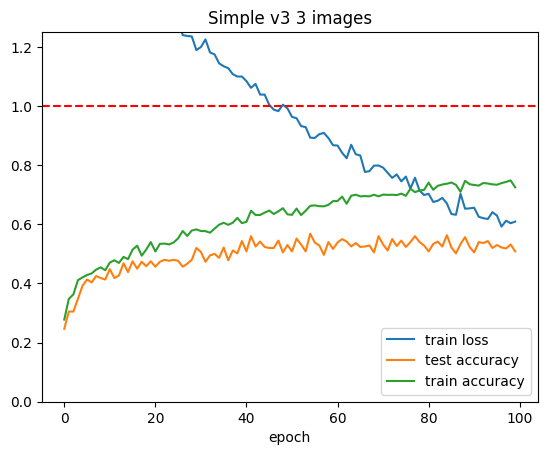

In [ ]:
#for i in range(0,len(test_acc_list)):
#    test_acc_list[i] = test_acc_list[i]/100
#for i in range(0,len(train_acc_list)):
 #   train_acc_list[i] = train_acc_list[i]/100

plt.plot(losses_list,label='train loss')
plt.plot(test_acc_list,label='test accuracy')
plt.plot(train_acc_list,label = 'train accuracy')
plt.xlabel('epoch')
plt.title('Simple v3 3 images')
plt.axhline(y=1, xmin=0, xmax=100, ls='dashed',color='r')
plt.ylim((0,1.25))
plt.legend()
plt.show()

**TEST**


In [ ]:
# Show results for all the trained models
from sklearn.metrics import classification_report
from sklearn import metrics
import seaborn as sns

my_net = Simplev2()
my_net.load_state_dict(torch.load(results_path + 'Simple.ckpt'))
device = torch.device('cpu')

acc,pred = test(my_net, test_loader)
print('Accuracy MyNet: ' + str(acc))

Accuracy MyNet: 75.25
